# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project
## Milestone #4 - Baseline Model
**Harvard University**  
**Fall 2016**  
**Team**: Stephen Camera-Murray, Himani Garg, and Vijay Thangella  
**TF**: Christine Hwang  
  
**Due Date: ** Monday, November 28th, 2016 at 11:59pm

### Baseline Model

#### Import libraries

In [99]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn.linear_model import LogisticRegression

# suppress warnings
warnings.filterwarnings ( 'ignore' )
%matplotlib inline

#### Load the cleansed data

We begin by loading the listings dataset we saved after cleansing from milestone #3:  
- cleansed_listings.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed)  
  
**Note** - The baseline model is ignoring seasonality for now. If we can later determine that seasonality plays a large enough part in price prediction, we'll include it in our final model.

In [3]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings.tab.gz', sep = '\t', index_col = 'id', compression = 'gzip' )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,...,9.0,7.0,9.0,9.0,10.0,9.0,1,21,21,1
1846722,Apartment 20 Minutes Times Square,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,NaN,...,8.0,8.0,9.0,8.0,7.0,8.0,2,31,12,1


In [4]:
print ( 'The listings dataframe has {0} listings and {1} columns.' ).format ( listingsDF.shape [ 0 ], listingsDF.shape [ 1 ] )

The listings dataframe has 27392 listings and 30 columns.


The cleansed listings dataframe is the main dataset we'll be using for our baseline prediction. It has 12,591 listings and 31 columns. The columns are listed below.

In [5]:
print listingsDF.columns.values

['name' 'neighborhood' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'square_feet' 'price'
 'guests_included' 'minimum_nights' 'maximum_nights' 'availability_30'
 'availability_60' 'availability_90' 'availability_365' 'number_of_reviews'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count' 'months_as_host'
 'months_since_first_review' 'months_since_last_review']


Keeping in mind that our goal is to provide pricing guidance to new owners who wish to list their property, we've come up with three price groupings based on our data to have a nice balance between the groups **and** user-friendly ranges. As we can see from the distribution below (filtering out the handful of \$1000+ listings to improve the visualization) for one bedroom listings, there's a wide range. We'll create a new target variable to identify each listing for one of three categories:  
- Low: Up to \$130  
- Mid: \$130 - \$350  
- High: Over \$350  
  
**Note**: The distribution is different than in milestone #3. We discovered an error we made on the price column while cleansing the data and have since corrected it. Our price ranges have been updated as well.

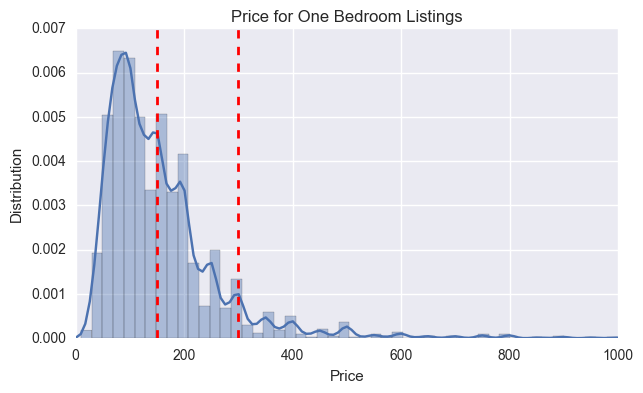

In [6]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of prices - filtering out the extreme highs
ax = sns.distplot ( listingsDF [ "price" ] [ listingsDF [ "price" ] < 1000 ] )

# set the labels
ax.set_title  ( "Price for One Bedroom Listings" )
ax.set_xlabel ( "Price" )
ax.set_ylabel ( "Distribution" )

ax.set_xlim ( 0, 1000 )

# set our price grouping cutoffs
plt.axvline ( 150, color = 'r', linestyle = 'dashed', linewidth = 2 )
plt.axvline ( 300, color = 'r', linestyle = 'dashed', linewidth = 2 )

# display the visualization
plt.show()

Now, let's create a price category column and drop the price column.

In [7]:
# create the price_category column based on our ranges
listingsDF [ "price_category" ] = "Low"
listingsDF [ "price_category" ][ ( listingsDF [ "price" ] >= 150 ) & ( listingsDF [ "price" ] <= 300 ) ] = "Mid"
listingsDF [ "price_category" ][ ( listingsDF [ "price" ] >  300 ) ] = "High"

# drop the price column
listingsDF.drop ( [ 'price' ], axis = 1, inplace = True )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
1846722,Apartment 20 Minutes Times Square,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,NaN,...,8.0,9.0,8.0,7.0,8.0,2,31,12,1,Low


Now let's see what the distribution is among the price categories.

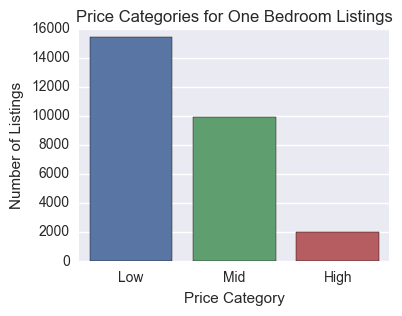

In [31]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 4, 3 ) } )
ax = plt.axes()

# create a barplot of the price categories
ax = sns.barplot ( x = listingsDF.price_category.value_counts().index
                 , y = listingsDF.price_category.value_counts() )

# set the labels
ax.set_title  ( "Price Categories for One Bedroom Listings" )
ax.set_xlabel ( "Price Category" )
ax.set_ylabel ( "Number of Listings" )

# display the visualization
plt.show()

Save the new dataset.

In [8]:
# save the listings dataframe as a tab-delimited, compressed file
listingsDF.to_csv ( './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index = False, compression = 'gzip' )

Split our dataframe into train and test and separate our predictors from the target.

In [13]:
# split our dataframe into train and test
train, test = train_test_split ( listingsDF, train_size = 0.6 )

# separate x's and y's
x_train = train.drop ( "price_category", axis = 1 )
x_test  = test.drop  ( "price_category", axis = 1 )
y_train = train [ "price_category" ]
y_test  = test  [ "price_category" ]

#### Establishing a baseline model  
  
Before we begin model building, we need to establish a baseline model to compare against our final model. Our goal is to provide pricing guidance to new owners who wish to list their property, we come up with three price groupings based on our data to have a nice balance between the groups and user-friendly ranges.  
  
We'll use the following models for our baselines:
- random selection
- majority model (the top category: Low)
- naive logistic regression  
  
These models will be applied to our testing dataset. But first, let's look at the proportion of listings in the test set that fall in to each price category.

In [44]:
# fetch the number of listings in the test dataset
num_listings = y_test.shape [ 0 ]

# print the price category percentages
print ( 'Percentage of listings with the price category Low: {0:.1f}%, Mid: {1:.1f}%, High: {2:.1f}%' ).format ( 100.0 * y_test.value_counts() [ 0 ] / num_listings, 100.0 * y_test.value_counts() [ 1 ] / num_listings, 100.0 * y_test.value_counts() [ 2 ] / num_listings )

Percentage of listings with the price category Low: 55.8%, Mid: 36.6%, High: 7.5%


Create a function to score our models.

In [137]:
# function to compute the accuracy of a given model
score = lambda model, x_test, y_test: pd.Series ( [ model.score ( x_test, y_test ), 
                                                    model.score ( x_test [ y_test == "Low" ],  y_test [ y_test == "Low" ]  ),
                                                    model.score ( x_test [ y_test == "Mid" ],  y_test [ y_test == "Mid" ]  ),
                                                    model.score ( x_test [ y_test == "High" ], y_test [ y_test == "High" ] ),
                                                    f1_score    ( y_test, model.predict ( x_test ), average = "weighted" ) ],
                                                    index = [ 'Overall Accuracy', 'Accuracy on Low Category', 'Accuracy on Mid Category', 'Accuracy on High Category', 'F1 Score'  ])

Create functions for our baseline models.

In [133]:
# model predicting random values
class random_model ( object ):
    def predict ( self, x ):
        cats = [ "Low", "Mid", "High" ]
        return np.random.choice ( cats, len ( x ), replace = True )

    def score(self, x, y):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting the majority: Low
class maj_model ( object ):
    def predict ( self, x ):
        return np.array ( [ "Low" ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

Build our models and score.

In [132]:
(z == y_test).sum()

6118

In [142]:
# build and score our baseline models
random              = random_model()
random_model_scores = score ( random,  x_test, y_test )

majority            = maj_model()
majority_scores     = score ( majority, x_test, y_test )

#logreg              = LogisticRegression()
#logreg.fit ( x_train, y_train )
#logreg_model_scores = score ( logreg,  x_test, y_test )

# print scores
score_df = pd.DataFrame ( { 'Random Model'              : random_model_scores,
                            'Majority Model'            : majority_scores } )
#                            'Logistic Regression Model' : logreg_model_scores } )
score_df

,Majority Model,Random Model
Overall Accuracy,0.558365,0.331113
Accuracy on Low Category,1.000000,0.328212
Accuracy on Mid Category,0.000000,0.330842
Accuracy on High Category,0.000000,0.335758
F1 Score,0.400126,0.364101


- build classification models: random, all the major one, and naive log reg.
- closing remarks

****END****

In [48]:
np.array ( 'x' )

IndexError: too many indices for array

In [4]:
listingsDF.shape

(27392, 52)

The listings dataset is the main dataset we'll be using for prediction. It has 27,392 listings and 52 columns. As we can see from the names below, not all columns are suitable for prediction, but many of them are.

In [5]:
listingsDF.columns

Index([u'id', u'scrape_id', u'last_scraped', u'name', u'picture_url',
       u'host_id', u'host_name', u'host_since', u'host_picture_url', u'street',
       u'neighbourhood', u'neighbourhood_cleansed', u'city', u'state',
       u'zipcode', u'market', u'country', u'latitude', u'longitude',
       u'is_location_exact', u'property_type', u'room_type', u'accommodates',
       u'bathrooms', u'bedrooms', u'beds', u'bed_type', u'square_feet',
       u'price', u'weekly_price', u'monthly_price', u'guests_included',
       u'extra_people', u'minimum_nights', u'maximum_nights',
       u'calendar_updated', u'availability_30', u'availability_60',
       u'availability_90', u'availability_365', u'calendar_last_scraped',
       u'number_of_reviews', u'first_review', u'last_review',
       u'review_scores_rating', u'review_scores_accuracy',
       u'review_scores_cleanliness', u'review_scores_checkin',
       u'review_scores_communication', u'review_scores_location',
       u'review_scores_value', u'h

The calendar dataset has pricing data for listings at different times of the week. We'll look at this one to see if there are different prices for seasonality.  
  
**Note**: we added a buffer column to the end of the dataset since there's a bit of messiness in the data.

In [6]:
# load listings data into a pandas df
calendarDF = pd.read_csv ( './datasets/calendar.csv.gz', skiprows = 1, usecols = [ 0, 1, 2, 3, 4 ], names = [ 'listing_id', 'date', 'available', 'price', 'buffer' ] )

# display the first two rows
calendarDF.head ( n = 2 )

,listing_id,date,available,price,buffer
0,3604481,2015-01-01,t,$600.00,NaN
1,3604481,2015-01-02,t,$600.00,NaN


In [7]:
calendarDF.shape

(9998080, 5)

#### Data Cleansing

**Listing dataset**

We notice that some listings have weekly and monthly rates, but almost all listings have a daily rate. We start by converting the price column to a float so we can work with it as a number. Next, we remove all columns that we don't plan to use for prediction: 'scrape_id', 'last_scraped', 'picture_url', 'host_id', 'host_name', 'host_picture_url', 'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market', 'country', 'latitude', 'longitude', 'is_location_exact', 'weekly_price', 'monthly_price', 'extra_people', 'calendar_updated', 'calendar_last_scraped'.

In [8]:
# convert the price column to a float
listingsDF [ 'price' ] = calendarDF [ 'price' ].replace ( '[\$,)]', '', regex = True ).replace ( '[(]', '-', regex = True ).astype ( float )

# drop columns we don't need
listingsDF.drop ( [ 'scrape_id', 'last_scraped', 'picture_url', 'host_id', 'host_name', 'host_picture_url', 'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market', 'country', 'latitude', 'longitude', 'is_location_exact', 'weekly_price', 'monthly_price', 'extra_people', 'calendar_updated', 'calendar_last_scraped' ], axis = 1, inplace = True )

# rename the neighbourhood_cleansed column to neighborhood
listingsDF = listingsDF.rename ( columns = { 'neighbourhood_cleansed' : 'neighborhood' } )

# display the first two rows
listingsDF.head ( n = 2 )

,id,name,host_since,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,1069266,Stay like a real New Yorker!,2013-04-10,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,...,2013-04-28,2014-12-17,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,1846722,Apartment 20 Minutes Times Square,2012-06-13,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,...,2014-01-05,2014-12-29,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2


Next, we'll convert all of the date fields to an integer representing the month age so we can better work with them.  
  
**Note**: the first_review and last_review columns may be blank. If they are we'll penalize them by setting it to the "worst" value in the data based on our assumption that the worst case for a first review is it's recent, or the lastest date in our data, and the last review is old, or the earliest date in our data.

In [9]:
# fill in missing dates with the "worst" value
listingsDF [ "first_review" ][ listingsDF [ "first_review" ].isnull() ] = listingsDF [ "first_review" ][ listingsDF [ "first_review" ].notnull() ].max()
listingsDF [ "last_review"  ][ listingsDF [ "last_review"  ].isnull() ] = listingsDF [ "last_review"  ][ listingsDF [ "last_review"  ].notnull() ].min()

# create new date fields based on a months passed
listingsDF [ "months_as_host" ] = ( ( 2014 - listingsDF [ "host_since" ].str [ : 4 ].astype ( int ) ) * 12 ) + ( 13 - listingsDF [ "host_since" ].str [ 5 : 7 ].astype ( int ) )
listingsDF [ "months_since_first_review" ] = ( ( 2014 - listingsDF [ "first_review" ].str [ : 4 ].astype ( int ) ) * 12 ) + ( 13 - listingsDF [ "first_review" ].str [ 5 : 7 ].astype ( int ) )
listingsDF [ "months_since_last_review"  ] = ( ( 2014 - listingsDF [ "last_review"  ].str [ : 4 ].astype ( int ) ) * 12 ) + ( 13 - listingsDF [ "last_review"  ].str [ 5 : 7 ].astype ( int ) )

# drop columns we don't need
listingsDF.drop ( [ 'host_since', 'first_review', 'last_review' ], axis = 1, inplace = True )

# display the first two rows
listingsDF.head ( n = 2 )

,id,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review
0,1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,...,9.0,7.0,9.0,9.0,10.0,9.0,1,21,21,1
1,1846722,Apartment 20 Minutes Times Square,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,...,8.0,8.0,9.0,8.0,7.0,8.0,2,31,12,1


**Calendar listing data**

We start by converting the price to a float so we can work with it as a number and drop the buffer column.

In [10]:
# convert the price column to a float
calendarDF [ 'price' ] = calendarDF [ 'price' ].replace ( '[\$,)]', '', regex = True ).replace ( '[(]', '-', regex = True ).astype ( float )

# drop the buffer column
calendarDF.drop ( [ 'buffer' ], axis = 1, inplace = True )

# display the first two rows
calendarDF.head ( n = 2 )

,listing_id,date,available,price
0,3604481,2015-01-01,t,600.0
1,3604481,2015-01-02,t,600.0


Next, we add a seasonal column by extracting the month and applying some simple logic.

In [11]:
# create a season column for the calendar listing prices by: 1) extract the month to a separate column,
# and 2) create a season column based on the month
calendarDF [ "month" ] = calendarDF [ "date" ].str [ 5 : 7 ].astype ( int )
calendarDF [ "season" ] = "Winter"
calendarDF [ "season" ][ ( calendarDF [ 'month' ] >= 3 ) &  ( calendarDF [ 'month' ] <= 5 ) ] = "Spring"
calendarDF [ "season" ][ ( calendarDF [ 'month' ] >= 6 ) &  ( calendarDF [ 'month' ] <= 8 ) ] = "Summer"
calendarDF [ "season" ][ ( calendarDF [ 'month' ] >= 9 ) &  ( calendarDF [ 'month' ] <= 11 ) ] = "Fall"

# display the first two rows
calendarDF.head ( n = 2 )

,listing_id,date,available,price,month,season
0,3604481,2015-01-01,t,600.0,1,Winter
1,3604481,2015-01-02,t,600.0,1,Winter


Finally, we group the listings and seasons to get the mean listing price for the season.

In [12]:
# get rid of rows with blank or meaningless prices
calendarDF = calendarDF [ np.isfinite ( calendarDF [ 'price' ] ) ]

# create a seasonal dataframe with average seasonal pricing for each listing
seasonalDF = calendarDF.groupby ( [ 'listing_id', 'season' ] ) [ 'price' ].mean().to_frame ( name = 'price' ).reset_index()

seasonalDF.head ( n = 2 )

,listing_id,season,price
0,105,Fall,363.285714
1,105,Spring,360.956522


### Visualization and Analysis

**Pricing Categories**

We'll begin by looking at the distribution for price to see if there are any obvious ranges we might choose. We begin by looking at the number of bedrooms and room types to see if New York City has similar phenomenon as San Francisco where most listings are for one bedroom and not shared rooms.

In [13]:
# a little cleanup first: remove rows without price or bedroom data
listingsDF = listingsDF [ np.isfinite ( listingsDF [ "bedrooms" ] ) & np.isfinite ( listingsDF [ "price" ] ) ]

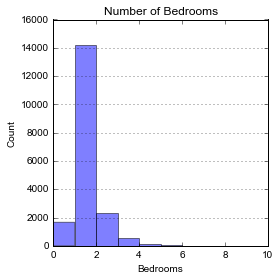

In [14]:
# set up our visualization
fig, ax = plt.subplots ( 1, 1, figsize = ( 4, 4 ) )

# set the style
plt.style.use ( [ 'seaborn-white', 'seaborn-muted' ] )
matplotlib.rc ( "font", family = "Times New Roman" )

# create histogram
ax.hist ( listingsDF [ "bedrooms" ], alpha = 0.5 )

# set labels
ax.set_title  ( "Number of Bedrooms" )
ax.yaxis.grid ( True )
ax.set_xlabel ( "Bedrooms" )
ax.set_ylabel ( "Count" )

# display plot
plt.tight_layout()
plt.show()

As we suspected, the vast majority of the listings are one bedroom. Let's filter the data to only include those for prediction and look at our price distribution. But we also, look at the room type as well to see if we should filter out shared rooms, which are also likely to be less common.

In [15]:
listingsDF.groupby ( [ 'room_type' ] ) [ 'room_type' ].count().to_frame ( name = 'count' ).reset_index()

,room_type,count
0,Entire home/apt,11001
1,Private room,7348
2,Shared room,572


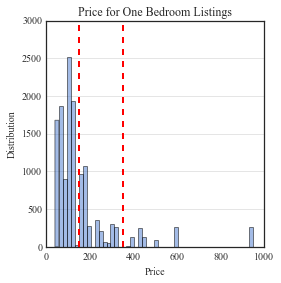

In [16]:
# filter out non-one bedroom listings
listingsDF = listingsDF [ ( listingsDF [ "bedrooms" ] == 1 ) & ( listingsDF [ "room_type" ] != "Shared room" ) ]

# set up our visualization
fig, ax = plt.subplots ( 1, 1, figsize = ( 4, 4 ) )

# create histogram
ax.hist ( listingsDF [ "price" ], alpha = 0.5, bins = 50 )

# set labels
ax.set_title  ( "Price for One Bedroom Listings" )
ax.yaxis.grid ( True )
ax.set_xlabel ( "Price" )
ax.set_ylabel ( "Distribution" )

# set our price grouping cutoffs
plt.axvline ( 150, color = 'r', linestyle = 'dashed', linewidth = 2 )
plt.axvline ( 350, color = 'r', linestyle = 'dashed', linewidth = 2 )

# display plot
plt.tight_layout()
plt.show()

Keeping in mind that our goal is to provide pricing guidance to new owners who wish to list their property, we come up with three price groupings based on our data to have a nice balance between the groups **and** user-friendly ranges. We can see the split in the histogram as:  
- Low: Up to \$150  
- Mid: \$150 - \$350  
- High: Over \$350  

**Listing Predictors**

**Predictor Distribution**

Now, let's look at the distributions of our numeric predictors. But, first, we'll need to do a little cleanup for missing values, setting them to something we believe is appropriate for now.

In [17]:
# set up our the list of columns to visualize
cols = [ "accommodates", "bathrooms", "beds", "square_feet", "guests_included", "minimum_nights", "maximum_nights"
        ,"availability_30", "availability_60", "availability_90", "availability_365", "number_of_reviews"
        ,"review_scores_rating", "host_listing_count", "months_as_host", "months_since_first_review", "months_since_last_review"
        ,"review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication"
        ,"review_scores_location", "review_scores_value" ]

# fill in missing values for certain columns with 1 or 0, depending
listingsDF [ "bathrooms" ][ listingsDF [ "bathrooms" ].isnull() ] = 1  # assume 1 if missing
listingsDF [ "beds" ][ listingsDF [ "beds" ].isnull() ] = 1  # assume 1 if missing
listingsDF [ "square_feet" ][ listingsDF [ "square_feet" ].isnull() ] = 1  # can't assum here, set to 0 so it stands out in the viz

# loop through the cols and fill in any other missing value with the mean
for i in cols:
    listingsDF [ i ][ listingsDF [ i ].isnull() ] = listingsDF [ i ][ listingsDF [ i ].notnull() ].mean()  # set to mean if missing

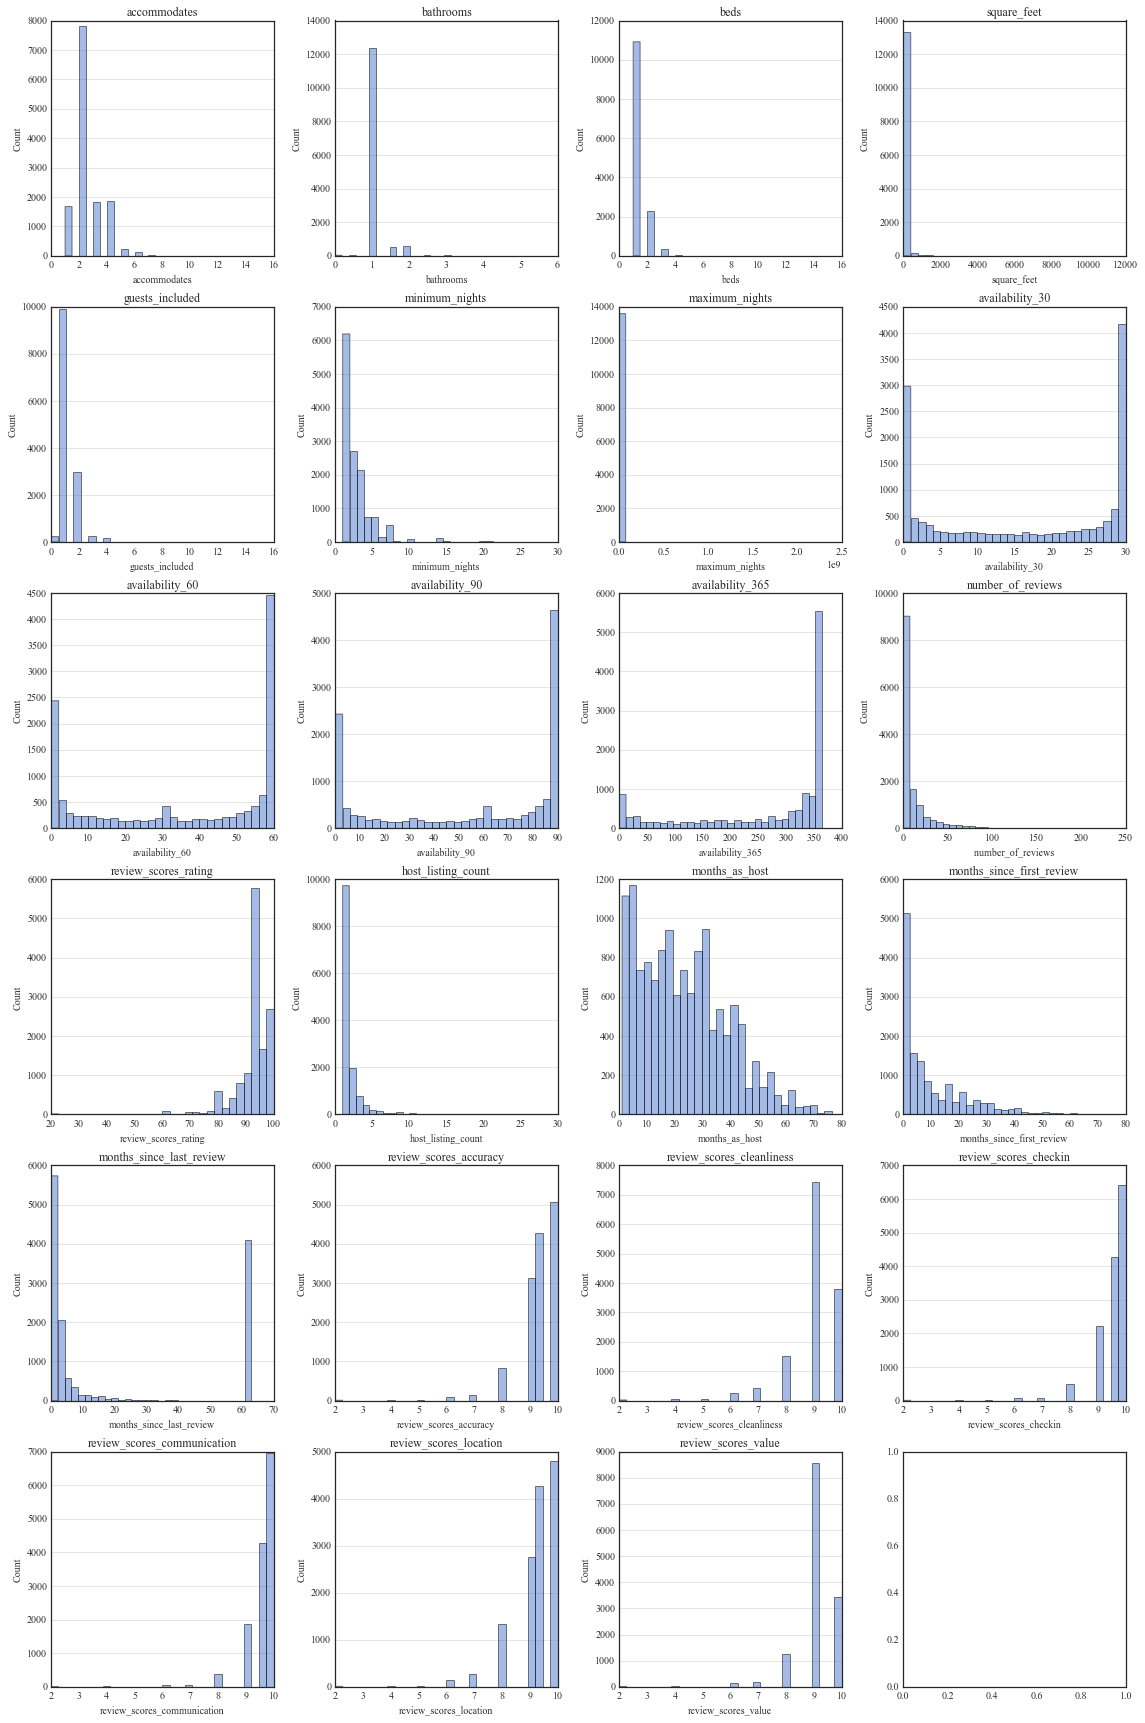

In [18]:
# set up our visualization
fig, ax = plt.subplots ( 6, 4, figsize = ( 16, 24 ) )

# loop through cols
for i in range ( len ( cols ) ):

    # create histogram
    ax [ ( i / 4 ), ( i % 4 ) ].hist ( listingsDF [ cols [ i ] ], alpha = 0.5, bins = 30 )

    # set labels
    ax [ ( i / 4 ), ( i % 4 ) ].set_title  ( cols [ i ] )
    ax [ ( i / 4 ), ( i % 4 ) ].set_xlabel ( cols [ i ] )
    ax [ ( i / 4 ), ( i % 4 ) ].set_ylabel ( "Count" )
    ax [ ( i / 4 ), ( i % 4 ) ].yaxis.grid ( True )

# display plot
plt.tight_layout()
plt.show()

From our numeric predictor distributions we can see that some of them may not have enough variety to make them meaningful for prediction. For instance, square_feet and maximum_nights are missing for most (defaulted to zero) and bathrooms are 1 for most listings. We'll likely drop them for making our predictions.

**Price vs. Individual numeric predictors**

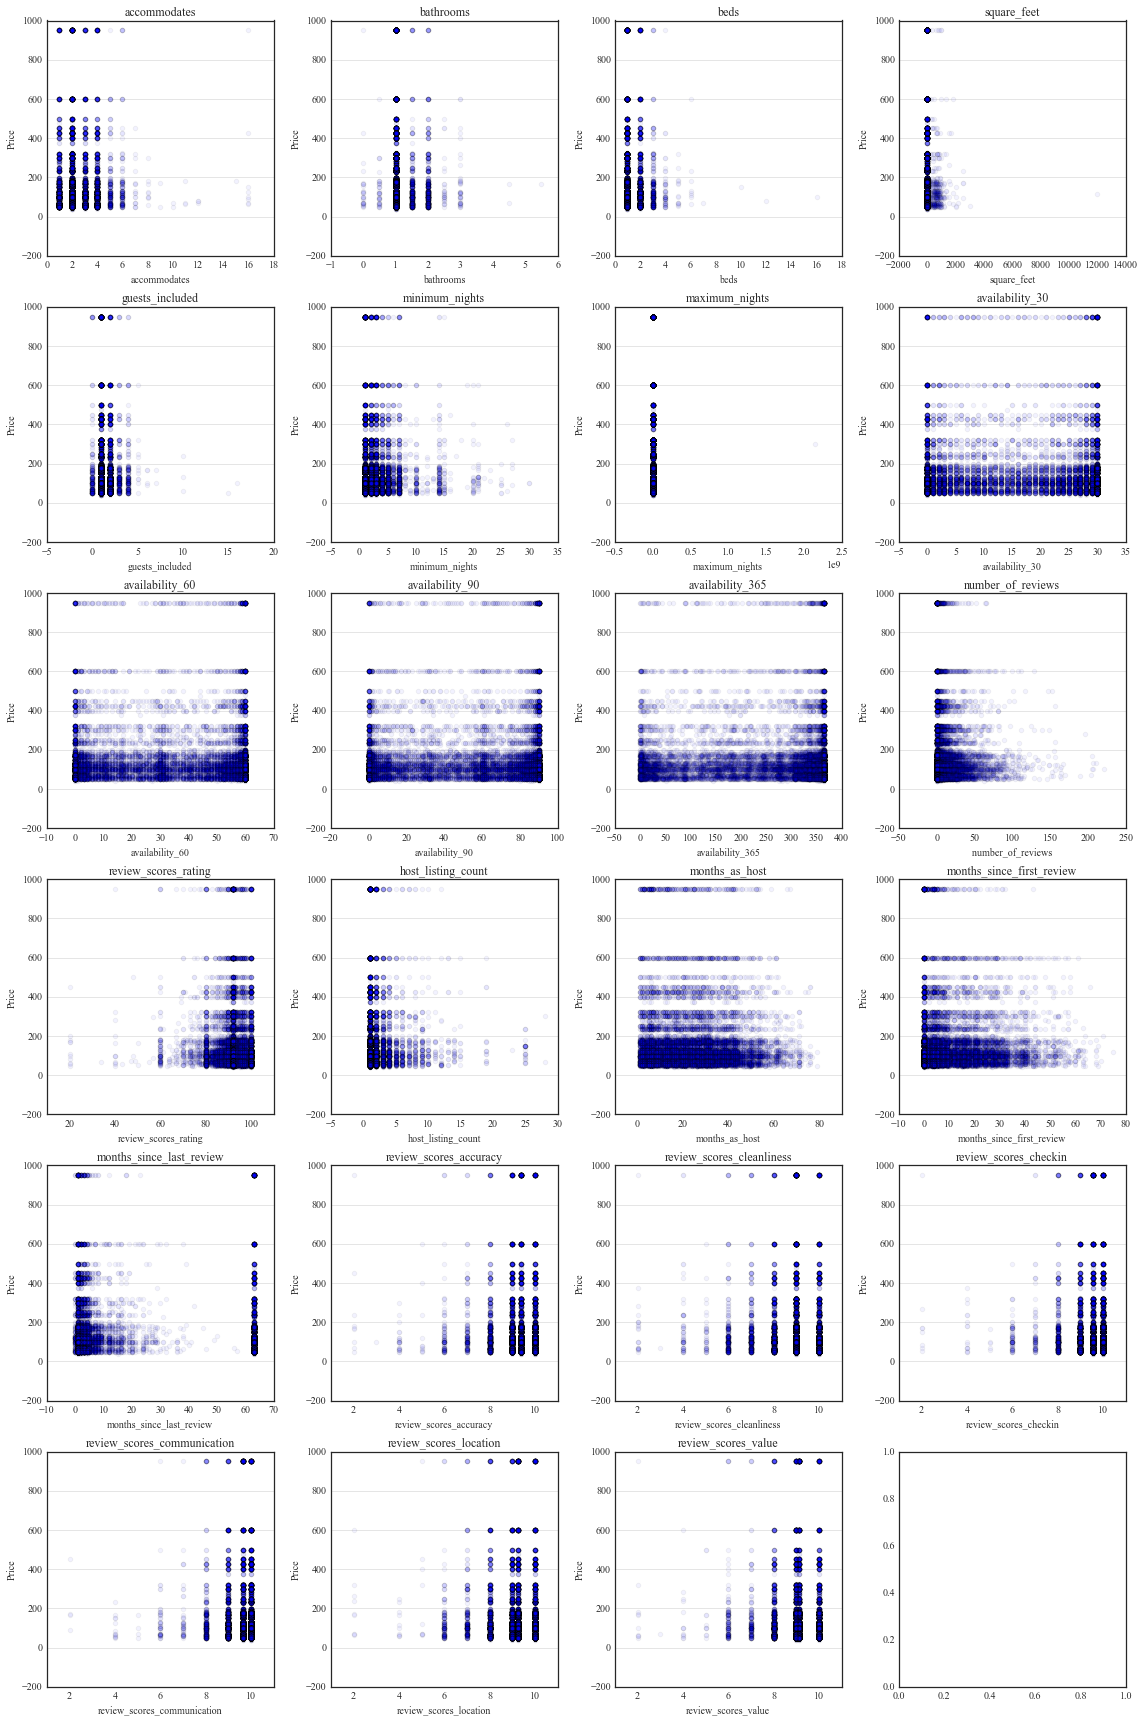

In [19]:
# set up our visualization
fig, ax = plt.subplots ( 6, 4, figsize = ( 16, 24 ) )

# loop through cols
for i in range ( len ( cols ) ):

    # create histogram
    ax [ ( i / 4 ), ( i % 4 ) ].scatter ( listingsDF [ cols [ i ] ], listingsDF [ "price" ], alpha = 0.05 )

    # set labels
    ax [ ( i / 4 ), ( i % 4 ) ].set_title  ( cols [ i ] )
    ax [ ( i / 4 ), ( i % 4 ) ].set_xlabel ( cols [ i ] )
    ax [ ( i / 4 ), ( i % 4 ) ].set_ylabel ( "Price" )
    ax [ ( i / 4 ), ( i % 4 ) ].yaxis.grid ( True )

# display plot
plt.tight_layout()
plt.show()

We see some general shape for many of our scatterplots of price vs. individual numeric predictors, indicating there is an association for many of them and they should be included in our model.

#### Seasonality

Next, we'll look at the effect on seasonality on listing prices.

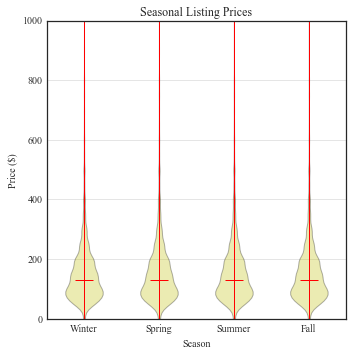

In [20]:
# parse out the seasonal pricing data
seasons = [ "Winter", "Spring", "Summer", "Fall" ]
df = [ seasonalDF [ "price" ][ ( seasonalDF [ "season" ] == season ) ].values for season in seasons ]

# set up our visualization
fig, ax = plt.subplots ( 1, 1, figsize = ( 5, 5 ) )

# create violin plot
ax.violinplot ( df, showmeans = False, showmedians = True )

# set labels
ax.set_title  ( "Seasonal Listing Prices" )
ax.yaxis.grid ( True )
ax.set_xticks ( [ ( y + 1 ) for y in range ( len ( df ) ) ] )
ax.set_xlabel ( "Season" )
ax.set_ylabel ( "Price ($)" )

# add x-tick labels
plt.setp(ax, xticks = [ ( y + 1 ) for y in range ( len ( df ) ) ], xticklabels = seasons )

# display plot
plt.tight_layout()
plt.show()

From the visualization, we don't see much shift based on the season, perhaps we need to look at other seasonal effects such as holidays, back-to-school, or summer to see if there's a real effect. We'll delve deeper into the potential for seasonal effects from a holiday persepctive and/or through interactions (e.g. higher prices around the holidays to accommodate friends and relatives).

**Supply by neighborhood with their average prices **

Now we are going to look into the number of houses (supply) by neighborhood and its relationship to average price. We begin by filtering out neighborhoods with fewer than 70 listings.

In [22]:
# get listings for neighborhoods with more than 70 listings
listings_size = listingsDF.groupby ( [ 'neighborhood' ] ).size()
listingsMoreThan70 = listings_size [ listings_size > 70 ].index.values
listingsDF_70 = listingsDF [ listingsDF [ 'neighborhood' ].isin ( listingsMoreThan70 ) ]

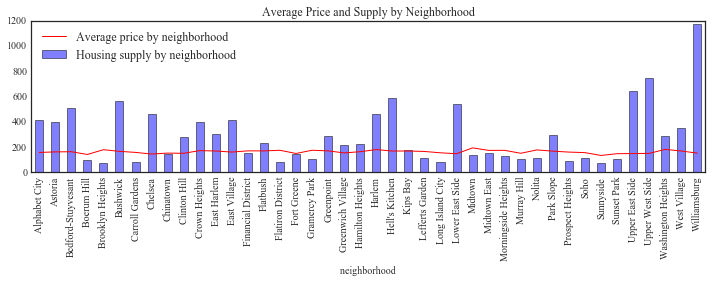

In [48]:
# set up visualization
fig1 = plt.figure ( figsize = ( 10, 4 ) )
ax1  = fig1.add_subplot ( 111 )

# plot the supply and mean price
listingsDF_70.groupby ( [ 'neighborhood' ] ) [ 'price' ].mean().plot (  kind  = 'line', color ='r', ax = ax1
                                                                       ,label = 'Average price by neighborhood' )
listingsDF_70.groupby ( [ 'neighborhood' ] ).size().plot (  kind  = 'bar', ax = ax1, color = 'b'
                                                           ,label = 'Housing supply by neighborhood', alpha = 0.5 )
plt.title  ( 'Average Price and Supply by Neighborhood')

# generate the display
plt.tight_layout()
plt.legend ( loc = 'best' )
plt.show()

We can clearly see here the supply of Airbnb house rentals vary by neighborhood and the average house prices by region varies between neighborhoods as well. Let's go in to more detail on average prices by neighborhood as the y-axis range is different for both graphs.

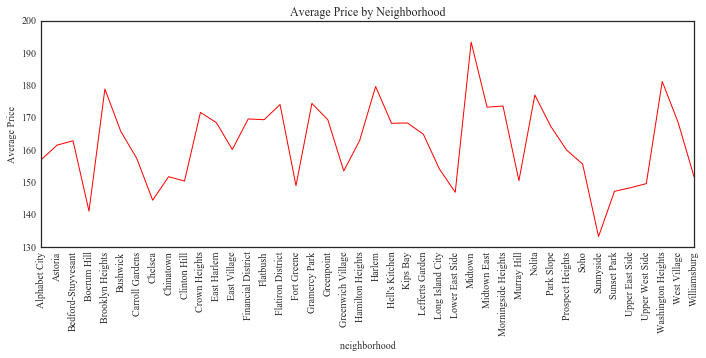

In [47]:
# set up the visualization
fig = plt.figure ( figsize = ( 10, 4 ) )

# set up the line graph
y = listingsDF_70.groupby ( [ 'neighborhood' ] )[ 'price' ].mean()
y.plot ( kind = 'line', color = 'r' )
x = range ( len ( y.values ) )

# create labels and 
plt.ylabel ( 'Average Price' )
plt.title  ( 'Average Price by Neighborhood')
plt.tight_layout()
labels = list ( y.index.values )
plt.xticks ( x, labels, rotation = 'vertical' )

# display visualization
plt.show()

In this plot we can clearly the average price changes between neighborhoods. This may be helpful for predicting prices in those neighborhoods if we decide to use priors to improve our predictions.